# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

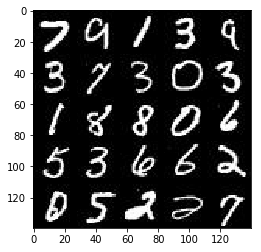

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

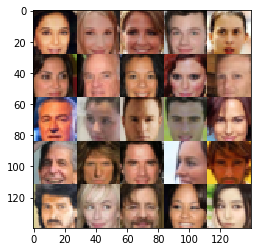

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    lr = tf.placeholder(tf.float32, name='learning_rate')

    return input_real, input_z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    k_init = tf.random_normal_initializer(stddev=0.02)
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, kernel_initializer=k_init, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, kernel_initializer=k_init, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, kernel_initializer=k_init, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    k_init = tf.random_normal_initializer(stddev=0.02)
    
    with tf.variable_scope('generator', reuse=(not is_train)):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*256)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x256 now
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=1, kernel_initializer=k_init, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 7x7x128 now
        
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, kernel_initializer=k_init, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 14x14x64 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, kernel_initializer=k_init, padding='same')
        # 28x28x3 now
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_real_out, d_real_logits = discriminator(input_real)
    d_fake_out, d_fake_logits = discriminator(g_model, reuse=True)
    
    smooth = 0.1
    real_labels = tf.ones_like(d_real_out) * (1 - smooth)
    fake_labels = tf.zeros_like(d_fake_out)
    g_labels    = tf.ones_like(d_fake_out)

    d_real_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_real_logits, labels=real_labels))
    d_fake_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_fake_logits, labels=fake_labels))
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_fake_logits, labels=g_labels))

    d_loss = d_real_loss + d_fake_loss
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    d_updates = [opt for opt in update_ops if opt.name.startswith('discriminator')]
    g_updates = [opt for opt in update_ops if opt.name.startswith('generator')]

    with tf.control_dependencies(d_updates):
        d_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)

    with tf.control_dependencies(g_updates):
        g_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
            
    return d_opt, g_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    print_every = 10
    show_every = 100
    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images *= 2.0
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z})

                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i + 1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.6601... Generator Loss: 1.5502
Epoch 1/2... Discriminator Loss: 0.5483... Generator Loss: 1.9128
Epoch 1/2... Discriminator Loss: 0.5066... Generator Loss: 2.1921
Epoch 1/2... Discriminator Loss: 0.8794... Generator Loss: 2.0895
Epoch 1/2... Discriminator Loss: 0.8769... Generator Loss: 1.4664
Epoch 1/2... Discriminator Loss: 0.7565... Generator Loss: 2.1055
Epoch 1/2... Discriminator Loss: 0.6503... Generator Loss: 2.6156
Epoch 1/2... Discriminator Loss: 0.5556... Generator Loss: 2.0255
Epoch 1/2... Discriminator Loss: 0.4545... Generator Loss: 2.9682
Epoch 1/2... Discriminator Loss: 0.6178... Generator Loss: 1.8572


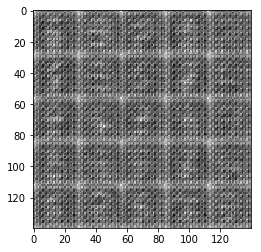

Epoch 1/2... Discriminator Loss: 0.8473... Generator Loss: 1.1427
Epoch 1/2... Discriminator Loss: 0.5557... Generator Loss: 2.1779
Epoch 1/2... Discriminator Loss: 1.0587... Generator Loss: 0.8401
Epoch 1/2... Discriminator Loss: 0.6006... Generator Loss: 2.0921
Epoch 1/2... Discriminator Loss: 1.4291... Generator Loss: 0.5646
Epoch 1/2... Discriminator Loss: 1.0987... Generator Loss: 3.8177
Epoch 1/2... Discriminator Loss: 0.8052... Generator Loss: 3.6754
Epoch 1/2... Discriminator Loss: 1.1762... Generator Loss: 0.6932
Epoch 1/2... Discriminator Loss: 1.0719... Generator Loss: 0.7467
Epoch 1/2... Discriminator Loss: 0.7278... Generator Loss: 1.3348


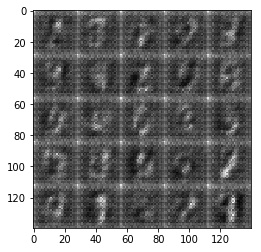

Epoch 1/2... Discriminator Loss: 0.6450... Generator Loss: 2.2004
Epoch 1/2... Discriminator Loss: 0.6380... Generator Loss: 2.2026
Epoch 1/2... Discriminator Loss: 0.6716... Generator Loss: 1.5283
Epoch 1/2... Discriminator Loss: 0.7330... Generator Loss: 1.2530
Epoch 1/2... Discriminator Loss: 0.5548... Generator Loss: 2.3238
Epoch 1/2... Discriminator Loss: 0.8453... Generator Loss: 2.8930
Epoch 1/2... Discriminator Loss: 0.6525... Generator Loss: 2.3332
Epoch 1/2... Discriminator Loss: 0.6092... Generator Loss: 1.8824
Epoch 1/2... Discriminator Loss: 0.9112... Generator Loss: 1.0949
Epoch 1/2... Discriminator Loss: 0.8351... Generator Loss: 1.0944


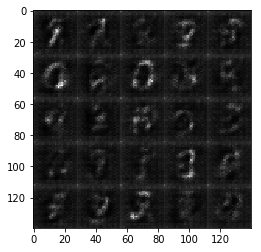

Epoch 1/2... Discriminator Loss: 0.6083... Generator Loss: 1.8302
Epoch 1/2... Discriminator Loss: 0.9962... Generator Loss: 0.9012
Epoch 1/2... Discriminator Loss: 0.7170... Generator Loss: 1.3133
Epoch 1/2... Discriminator Loss: 0.6375... Generator Loss: 2.1899
Epoch 1/2... Discriminator Loss: 0.6515... Generator Loss: 1.9620
Epoch 1/2... Discriminator Loss: 0.6439... Generator Loss: 2.7295
Epoch 1/2... Discriminator Loss: 0.5542... Generator Loss: 2.1317
Epoch 1/2... Discriminator Loss: 0.6318... Generator Loss: 2.3590
Epoch 1/2... Discriminator Loss: 0.7250... Generator Loss: 2.7836
Epoch 1/2... Discriminator Loss: 0.6913... Generator Loss: 1.4270


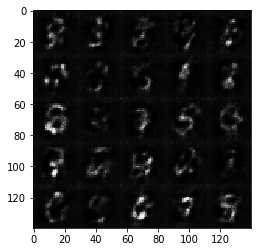

Epoch 1/2... Discriminator Loss: 0.5646... Generator Loss: 1.7608
Epoch 1/2... Discriminator Loss: 0.6694... Generator Loss: 2.6556
Epoch 1/2... Discriminator Loss: 0.8053... Generator Loss: 1.1518
Epoch 1/2... Discriminator Loss: 0.5793... Generator Loss: 1.7936
Epoch 1/2... Discriminator Loss: 0.8278... Generator Loss: 1.0605
Epoch 1/2... Discriminator Loss: 0.6302... Generator Loss: 1.6802
Epoch 1/2... Discriminator Loss: 0.9264... Generator Loss: 3.6372
Epoch 1/2... Discriminator Loss: 0.6468... Generator Loss: 1.5778
Epoch 1/2... Discriminator Loss: 0.6814... Generator Loss: 2.9329
Epoch 1/2... Discriminator Loss: 0.5704... Generator Loss: 1.8191


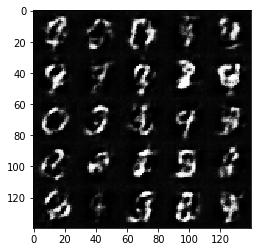

Epoch 1/2... Discriminator Loss: 0.6539... Generator Loss: 1.5197
Epoch 1/2... Discriminator Loss: 0.8865... Generator Loss: 3.9287
Epoch 1/2... Discriminator Loss: 0.5666... Generator Loss: 2.0758
Epoch 1/2... Discriminator Loss: 0.5831... Generator Loss: 1.7971
Epoch 1/2... Discriminator Loss: 0.5999... Generator Loss: 1.9174
Epoch 1/2... Discriminator Loss: 0.7171... Generator Loss: 1.3359
Epoch 1/2... Discriminator Loss: 0.7463... Generator Loss: 3.1529
Epoch 1/2... Discriminator Loss: 0.5531... Generator Loss: 1.9255
Epoch 1/2... Discriminator Loss: 0.8850... Generator Loss: 1.0214
Epoch 1/2... Discriminator Loss: 0.5617... Generator Loss: 1.9774


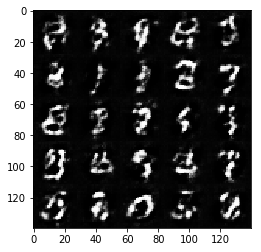

Epoch 1/2... Discriminator Loss: 0.7841... Generator Loss: 3.0456
Epoch 1/2... Discriminator Loss: 0.6031... Generator Loss: 1.8006
Epoch 1/2... Discriminator Loss: 0.5569... Generator Loss: 1.9059
Epoch 1/2... Discriminator Loss: 0.6058... Generator Loss: 1.7608
Epoch 1/2... Discriminator Loss: 1.2473... Generator Loss: 4.2329
Epoch 1/2... Discriminator Loss: 0.6131... Generator Loss: 1.7524
Epoch 1/2... Discriminator Loss: 0.6133... Generator Loss: 1.8091
Epoch 1/2... Discriminator Loss: 0.5792... Generator Loss: 2.6489
Epoch 1/2... Discriminator Loss: 0.6275... Generator Loss: 2.1369
Epoch 1/2... Discriminator Loss: 0.6423... Generator Loss: 2.6420


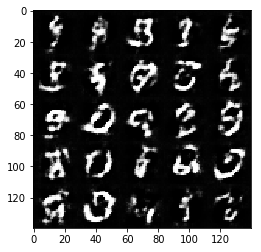

Epoch 1/2... Discriminator Loss: 0.9945... Generator Loss: 0.8529
Epoch 1/2... Discriminator Loss: 0.6389... Generator Loss: 2.8695
Epoch 1/2... Discriminator Loss: 0.6441... Generator Loss: 1.6087
Epoch 1/2... Discriminator Loss: 0.8216... Generator Loss: 1.1164
Epoch 1/2... Discriminator Loss: 0.5841... Generator Loss: 1.9323
Epoch 1/2... Discriminator Loss: 0.8496... Generator Loss: 3.2121
Epoch 1/2... Discriminator Loss: 0.6452... Generator Loss: 1.9974
Epoch 1/2... Discriminator Loss: 0.6594... Generator Loss: 2.6143
Epoch 1/2... Discriminator Loss: 0.6443... Generator Loss: 1.7153
Epoch 1/2... Discriminator Loss: 0.6840... Generator Loss: 2.4661


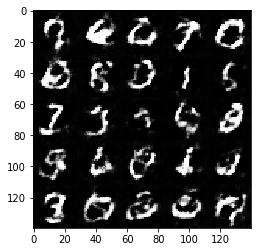

Epoch 1/2... Discriminator Loss: 1.0720... Generator Loss: 3.7218
Epoch 1/2... Discriminator Loss: 0.6651... Generator Loss: 1.9275
Epoch 1/2... Discriminator Loss: 0.6056... Generator Loss: 2.3067
Epoch 1/2... Discriminator Loss: 0.6932... Generator Loss: 1.5884
Epoch 1/2... Discriminator Loss: 0.6446... Generator Loss: 2.4465
Epoch 1/2... Discriminator Loss: 1.3083... Generator Loss: 3.7458
Epoch 1/2... Discriminator Loss: 0.9962... Generator Loss: 0.8394
Epoch 1/2... Discriminator Loss: 0.8504... Generator Loss: 2.8853
Epoch 1/2... Discriminator Loss: 0.7248... Generator Loss: 2.1793
Epoch 1/2... Discriminator Loss: 1.0838... Generator Loss: 0.7751


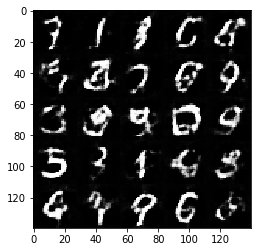

Epoch 1/2... Discriminator Loss: 0.6463... Generator Loss: 1.9685
Epoch 1/2... Discriminator Loss: 0.5797... Generator Loss: 1.7995
Epoch 1/2... Discriminator Loss: 1.0488... Generator Loss: 0.8611
Epoch 2/2... Discriminator Loss: 0.6557... Generator Loss: 1.4673
Epoch 2/2... Discriminator Loss: 0.6646... Generator Loss: 1.7332
Epoch 2/2... Discriminator Loss: 0.6701... Generator Loss: 1.5093
Epoch 2/2... Discriminator Loss: 0.7142... Generator Loss: 1.4071
Epoch 2/2... Discriminator Loss: 1.1519... Generator Loss: 0.7645
Epoch 2/2... Discriminator Loss: 0.9259... Generator Loss: 0.9525
Epoch 2/2... Discriminator Loss: 0.9721... Generator Loss: 0.9020


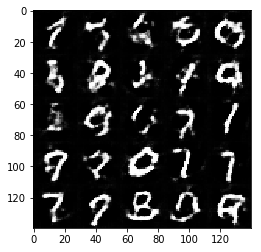

Epoch 2/2... Discriminator Loss: 0.9119... Generator Loss: 3.1006
Epoch 2/2... Discriminator Loss: 0.7020... Generator Loss: 1.8174
Epoch 2/2... Discriminator Loss: 0.8783... Generator Loss: 1.0794
Epoch 2/2... Discriminator Loss: 0.7662... Generator Loss: 1.5044
Epoch 2/2... Discriminator Loss: 0.9416... Generator Loss: 0.9553
Epoch 2/2... Discriminator Loss: 0.7999... Generator Loss: 1.1492
Epoch 2/2... Discriminator Loss: 0.7340... Generator Loss: 1.5899
Epoch 2/2... Discriminator Loss: 0.7268... Generator Loss: 1.5630
Epoch 2/2... Discriminator Loss: 1.0862... Generator Loss: 0.7970
Epoch 2/2... Discriminator Loss: 0.8109... Generator Loss: 1.1531


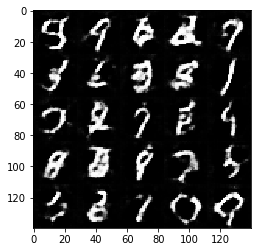

Epoch 2/2... Discriminator Loss: 0.7624... Generator Loss: 1.2811
Epoch 2/2... Discriminator Loss: 0.7005... Generator Loss: 1.5100
Epoch 2/2... Discriminator Loss: 0.7343... Generator Loss: 2.1944
Epoch 2/2... Discriminator Loss: 0.7440... Generator Loss: 1.2976
Epoch 2/2... Discriminator Loss: 0.9182... Generator Loss: 0.9131
Epoch 2/2... Discriminator Loss: 0.7214... Generator Loss: 2.2212
Epoch 2/2... Discriminator Loss: 0.6958... Generator Loss: 1.5048
Epoch 2/2... Discriminator Loss: 0.7722... Generator Loss: 1.9638
Epoch 2/2... Discriminator Loss: 0.9219... Generator Loss: 0.9629
Epoch 2/2... Discriminator Loss: 0.6990... Generator Loss: 1.7878


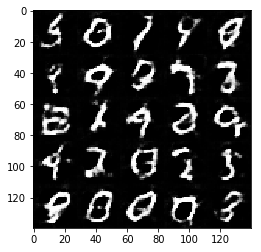

Epoch 2/2... Discriminator Loss: 1.0378... Generator Loss: 0.8184
Epoch 2/2... Discriminator Loss: 0.9192... Generator Loss: 0.9595
Epoch 2/2... Discriminator Loss: 0.9033... Generator Loss: 1.0693
Epoch 2/2... Discriminator Loss: 0.7846... Generator Loss: 1.2721
Epoch 2/2... Discriminator Loss: 0.7463... Generator Loss: 1.3123
Epoch 2/2... Discriminator Loss: 0.8100... Generator Loss: 1.1482
Epoch 2/2... Discriminator Loss: 0.7502... Generator Loss: 2.0972
Epoch 2/2... Discriminator Loss: 0.7188... Generator Loss: 1.6058
Epoch 2/2... Discriminator Loss: 0.8978... Generator Loss: 0.9692
Epoch 2/2... Discriminator Loss: 0.7150... Generator Loss: 1.5913


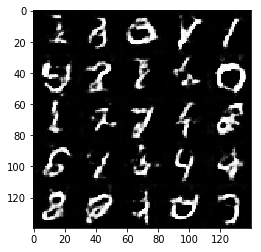

Epoch 2/2... Discriminator Loss: 0.7279... Generator Loss: 1.3920
Epoch 2/2... Discriminator Loss: 0.8217... Generator Loss: 1.1373
Epoch 2/2... Discriminator Loss: 0.7306... Generator Loss: 1.9186
Epoch 2/2... Discriminator Loss: 0.6890... Generator Loss: 1.7551
Epoch 2/2... Discriminator Loss: 0.7093... Generator Loss: 1.3900
Epoch 2/2... Discriminator Loss: 0.9843... Generator Loss: 0.8751
Epoch 2/2... Discriminator Loss: 0.7286... Generator Loss: 1.3482
Epoch 2/2... Discriminator Loss: 1.0351... Generator Loss: 2.7541
Epoch 2/2... Discriminator Loss: 0.7018... Generator Loss: 1.9778
Epoch 2/2... Discriminator Loss: 0.6740... Generator Loss: 1.7473


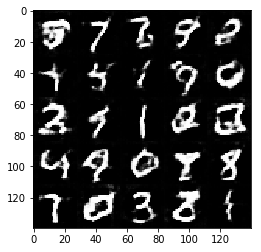

Epoch 2/2... Discriminator Loss: 0.6890... Generator Loss: 1.4904
Epoch 2/2... Discriminator Loss: 0.6984... Generator Loss: 1.5244
Epoch 2/2... Discriminator Loss: 0.8054... Generator Loss: 1.1962
Epoch 2/2... Discriminator Loss: 0.8822... Generator Loss: 0.9701
Epoch 2/2... Discriminator Loss: 0.6678... Generator Loss: 2.3215
Epoch 2/2... Discriminator Loss: 0.8081... Generator Loss: 1.1552
Epoch 2/2... Discriminator Loss: 0.7192... Generator Loss: 1.3597
Epoch 2/2... Discriminator Loss: 0.7319... Generator Loss: 1.7804
Epoch 2/2... Discriminator Loss: 0.7557... Generator Loss: 1.7140
Epoch 2/2... Discriminator Loss: 0.7019... Generator Loss: 1.3911


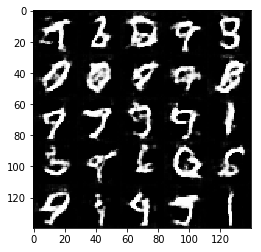

Epoch 2/2... Discriminator Loss: 0.7453... Generator Loss: 1.3782
Epoch 2/2... Discriminator Loss: 0.9207... Generator Loss: 0.9892
Epoch 2/2... Discriminator Loss: 0.8783... Generator Loss: 0.9972
Epoch 2/2... Discriminator Loss: 0.8959... Generator Loss: 1.0657
Epoch 2/2... Discriminator Loss: 0.8394... Generator Loss: 1.0851
Epoch 2/2... Discriminator Loss: 0.7359... Generator Loss: 1.2784
Epoch 2/2... Discriminator Loss: 0.9125... Generator Loss: 1.0311
Epoch 2/2... Discriminator Loss: 0.7539... Generator Loss: 1.2653
Epoch 2/2... Discriminator Loss: 0.6237... Generator Loss: 2.0402
Epoch 2/2... Discriminator Loss: 1.0508... Generator Loss: 0.7720


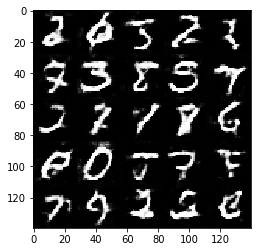

Epoch 2/2... Discriminator Loss: 0.9676... Generator Loss: 1.8646
Epoch 2/2... Discriminator Loss: 0.8218... Generator Loss: 1.1658
Epoch 2/2... Discriminator Loss: 0.6405... Generator Loss: 1.6489
Epoch 2/2... Discriminator Loss: 0.6630... Generator Loss: 2.0449
Epoch 2/2... Discriminator Loss: 0.7750... Generator Loss: 1.1858
Epoch 2/2... Discriminator Loss: 0.6201... Generator Loss: 1.8930
Epoch 2/2... Discriminator Loss: 0.7988... Generator Loss: 1.1143
Epoch 2/2... Discriminator Loss: 0.5818... Generator Loss: 1.9145
Epoch 2/2... Discriminator Loss: 0.6703... Generator Loss: 2.0651
Epoch 2/2... Discriminator Loss: 0.5868... Generator Loss: 1.8106


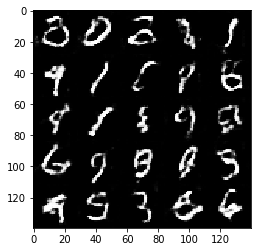

Epoch 2/2... Discriminator Loss: 0.6798... Generator Loss: 1.4083
Epoch 2/2... Discriminator Loss: 0.6352... Generator Loss: 2.3643
Epoch 2/2... Discriminator Loss: 0.6141... Generator Loss: 1.8617
Epoch 2/2... Discriminator Loss: 0.7380... Generator Loss: 2.4526
Epoch 2/2... Discriminator Loss: 1.8231... Generator Loss: 0.3556
Epoch 2/2... Discriminator Loss: 0.6805... Generator Loss: 1.5940
Epoch 2/2... Discriminator Loss: 0.6582... Generator Loss: 1.6443
Epoch 2/2... Discriminator Loss: 0.7520... Generator Loss: 1.3186
Epoch 2/2... Discriminator Loss: 0.7236... Generator Loss: 1.3416
Epoch 2/2... Discriminator Loss: 0.6021... Generator Loss: 2.0425


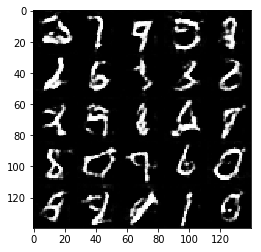

Epoch 2/2... Discriminator Loss: 0.6753... Generator Loss: 2.1739
Epoch 2/2... Discriminator Loss: 1.1089... Generator Loss: 0.7566
Epoch 2/2... Discriminator Loss: 0.7013... Generator Loss: 1.4005
Epoch 2/2... Discriminator Loss: 0.7496... Generator Loss: 1.3137
Epoch 2/2... Discriminator Loss: 0.6857... Generator Loss: 1.9279
Epoch 2/2... Discriminator Loss: 0.6870... Generator Loss: 1.3541
Epoch 2/2... Discriminator Loss: 0.6634... Generator Loss: 1.5335


In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.9930... Generator Loss: 0.9460
Epoch 1/1... Discriminator Loss: 0.7556... Generator Loss: 1.3062
Epoch 1/1... Discriminator Loss: 0.7521... Generator Loss: 1.3548
Epoch 1/1... Discriminator Loss: 0.7576... Generator Loss: 1.3180
Epoch 1/1... Discriminator Loss: 1.1123... Generator Loss: 7.2491
Epoch 1/1... Discriminator Loss: 0.5908... Generator Loss: 3.7531
Epoch 1/1... Discriminator Loss: 0.8034... Generator Loss: 2.5618
Epoch 1/1... Discriminator Loss: 1.3180... Generator Loss: 0.6002
Epoch 1/1... Discriminator Loss: 0.9404... Generator Loss: 1.0242
Epoch 1/1... Discriminator Loss: 0.9228... Generator Loss: 1.0858


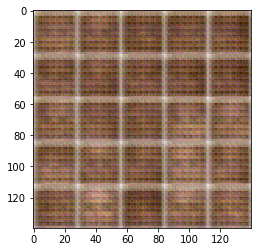

Epoch 1/1... Discriminator Loss: 0.6290... Generator Loss: 1.7212
Epoch 1/1... Discriminator Loss: 0.6914... Generator Loss: 2.4549
Epoch 1/1... Discriminator Loss: 0.7311... Generator Loss: 1.5938
Epoch 1/1... Discriminator Loss: 0.6126... Generator Loss: 2.6065
Epoch 1/1... Discriminator Loss: 0.8014... Generator Loss: 1.7069
Epoch 1/1... Discriminator Loss: 1.4228... Generator Loss: 0.5390
Epoch 1/1... Discriminator Loss: 0.9307... Generator Loss: 1.2182
Epoch 1/1... Discriminator Loss: 0.6971... Generator Loss: 1.8050
Epoch 1/1... Discriminator Loss: 1.4020... Generator Loss: 0.6723
Epoch 1/1... Discriminator Loss: 0.6271... Generator Loss: 2.7083


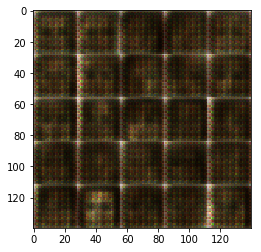

Epoch 1/1... Discriminator Loss: 0.9915... Generator Loss: 0.9485
Epoch 1/1... Discriminator Loss: 1.0343... Generator Loss: 1.3344
Epoch 1/1... Discriminator Loss: 1.2029... Generator Loss: 0.9203
Epoch 1/1... Discriminator Loss: 1.0733... Generator Loss: 1.1739
Epoch 1/1... Discriminator Loss: 1.3652... Generator Loss: 0.7360
Epoch 1/1... Discriminator Loss: 1.0251... Generator Loss: 0.9525
Epoch 1/1... Discriminator Loss: 1.2758... Generator Loss: 2.5193
Epoch 1/1... Discriminator Loss: 1.6982... Generator Loss: 0.4079
Epoch 1/1... Discriminator Loss: 1.2498... Generator Loss: 0.7351
Epoch 1/1... Discriminator Loss: 1.1918... Generator Loss: 0.8053


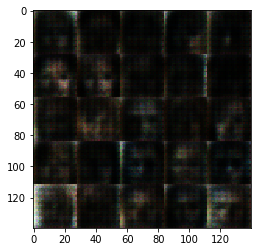

Epoch 1/1... Discriminator Loss: 1.2931... Generator Loss: 0.6245
Epoch 1/1... Discriminator Loss: 0.8442... Generator Loss: 1.4404
Epoch 1/1... Discriminator Loss: 1.1349... Generator Loss: 0.7392
Epoch 1/1... Discriminator Loss: 0.9705... Generator Loss: 1.6238
Epoch 1/1... Discriminator Loss: 1.1190... Generator Loss: 0.8818
Epoch 1/1... Discriminator Loss: 1.2409... Generator Loss: 1.2301
Epoch 1/1... Discriminator Loss: 0.8817... Generator Loss: 1.2112
Epoch 1/1... Discriminator Loss: 1.0786... Generator Loss: 1.5519
Epoch 1/1... Discriminator Loss: 0.9674... Generator Loss: 1.6611
Epoch 1/1... Discriminator Loss: 1.1939... Generator Loss: 1.4227


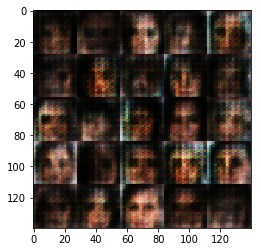

Epoch 1/1... Discriminator Loss: 1.8655... Generator Loss: 0.3366
Epoch 1/1... Discriminator Loss: 1.0906... Generator Loss: 2.0053
Epoch 1/1... Discriminator Loss: 0.9530... Generator Loss: 1.2015
Epoch 1/1... Discriminator Loss: 1.3165... Generator Loss: 0.6640
Epoch 1/1... Discriminator Loss: 1.0262... Generator Loss: 1.1640
Epoch 1/1... Discriminator Loss: 1.1742... Generator Loss: 1.5038
Epoch 1/1... Discriminator Loss: 1.0713... Generator Loss: 1.0006
Epoch 1/1... Discriminator Loss: 1.1843... Generator Loss: 1.3923
Epoch 1/1... Discriminator Loss: 1.6139... Generator Loss: 0.4116
Epoch 1/1... Discriminator Loss: 1.1745... Generator Loss: 1.0160


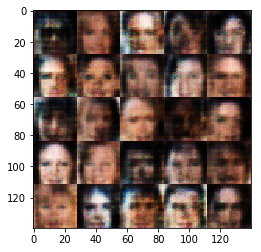

Epoch 1/1... Discriminator Loss: 1.4008... Generator Loss: 0.5654
Epoch 1/1... Discriminator Loss: 1.1138... Generator Loss: 1.6145
Epoch 1/1... Discriminator Loss: 1.3353... Generator Loss: 0.6742
Epoch 1/1... Discriminator Loss: 1.2356... Generator Loss: 2.3939
Epoch 1/1... Discriminator Loss: 0.9984... Generator Loss: 1.2917
Epoch 1/1... Discriminator Loss: 1.4700... Generator Loss: 1.1982
Epoch 1/1... Discriminator Loss: 1.1006... Generator Loss: 1.0685
Epoch 1/1... Discriminator Loss: 1.1532... Generator Loss: 0.7865
Epoch 1/1... Discriminator Loss: 1.3085... Generator Loss: 0.6311
Epoch 1/1... Discriminator Loss: 1.0164... Generator Loss: 1.0527


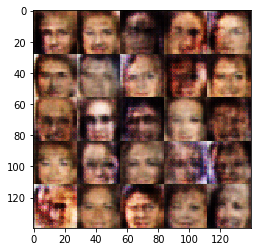

Epoch 1/1... Discriminator Loss: 0.9855... Generator Loss: 1.2045
Epoch 1/1... Discriminator Loss: 1.3329... Generator Loss: 1.2632
Epoch 1/1... Discriminator Loss: 1.0908... Generator Loss: 1.1268
Epoch 1/1... Discriminator Loss: 1.0456... Generator Loss: 1.0696
Epoch 1/1... Discriminator Loss: 1.2630... Generator Loss: 0.8355
Epoch 1/1... Discriminator Loss: 1.3963... Generator Loss: 1.4437
Epoch 1/1... Discriminator Loss: 1.3197... Generator Loss: 0.6276
Epoch 1/1... Discriminator Loss: 1.1589... Generator Loss: 0.8038
Epoch 1/1... Discriminator Loss: 1.3404... Generator Loss: 0.6791
Epoch 1/1... Discriminator Loss: 1.2688... Generator Loss: 0.8942


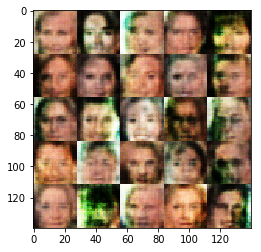

Epoch 1/1... Discriminator Loss: 1.0945... Generator Loss: 1.1713
Epoch 1/1... Discriminator Loss: 1.0637... Generator Loss: 1.2509
Epoch 1/1... Discriminator Loss: 1.4552... Generator Loss: 0.5783
Epoch 1/1... Discriminator Loss: 1.1217... Generator Loss: 1.7865
Epoch 1/1... Discriminator Loss: 0.9695... Generator Loss: 1.1383
Epoch 1/1... Discriminator Loss: 1.1236... Generator Loss: 1.1082
Epoch 1/1... Discriminator Loss: 1.2203... Generator Loss: 0.7721
Epoch 1/1... Discriminator Loss: 1.1740... Generator Loss: 0.7990
Epoch 1/1... Discriminator Loss: 1.0405... Generator Loss: 1.2902
Epoch 1/1... Discriminator Loss: 1.1599... Generator Loss: 1.4346


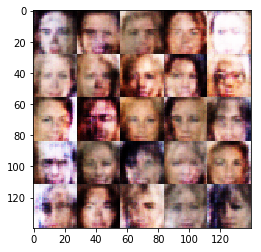

Epoch 1/1... Discriminator Loss: 1.2980... Generator Loss: 0.6346
Epoch 1/1... Discriminator Loss: 1.2027... Generator Loss: 1.2328
Epoch 1/1... Discriminator Loss: 1.0490... Generator Loss: 0.9091
Epoch 1/1... Discriminator Loss: 1.0767... Generator Loss: 0.9374
Epoch 1/1... Discriminator Loss: 1.2052... Generator Loss: 0.8976
Epoch 1/1... Discriminator Loss: 0.9881... Generator Loss: 1.9115
Epoch 1/1... Discriminator Loss: 1.3218... Generator Loss: 0.7849
Epoch 1/1... Discriminator Loss: 1.2015... Generator Loss: 1.3044
Epoch 1/1... Discriminator Loss: 1.1623... Generator Loss: 0.7964
Epoch 1/1... Discriminator Loss: 1.1871... Generator Loss: 0.7434


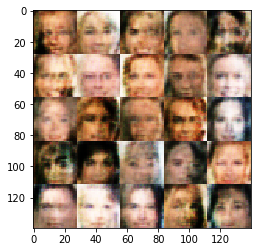

Epoch 1/1... Discriminator Loss: 1.2411... Generator Loss: 0.7887
Epoch 1/1... Discriminator Loss: 1.3394... Generator Loss: 0.6610
Epoch 1/1... Discriminator Loss: 1.2250... Generator Loss: 0.6888
Epoch 1/1... Discriminator Loss: 1.1018... Generator Loss: 0.9548
Epoch 1/1... Discriminator Loss: 0.9817... Generator Loss: 1.1066
Epoch 1/1... Discriminator Loss: 1.0701... Generator Loss: 1.0762
Epoch 1/1... Discriminator Loss: 1.0666... Generator Loss: 1.0664
Epoch 1/1... Discriminator Loss: 1.1400... Generator Loss: 0.8330
Epoch 1/1... Discriminator Loss: 1.0463... Generator Loss: 1.2241
Epoch 1/1... Discriminator Loss: 1.1489... Generator Loss: 0.8112


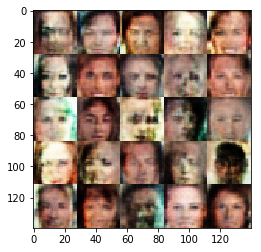

Epoch 1/1... Discriminator Loss: 1.1612... Generator Loss: 1.6023
Epoch 1/1... Discriminator Loss: 1.1497... Generator Loss: 1.0492
Epoch 1/1... Discriminator Loss: 1.1406... Generator Loss: 0.8118
Epoch 1/1... Discriminator Loss: 1.0006... Generator Loss: 1.1531
Epoch 1/1... Discriminator Loss: 1.4452... Generator Loss: 0.5734
Epoch 1/1... Discriminator Loss: 1.1017... Generator Loss: 1.2512
Epoch 1/1... Discriminator Loss: 1.1219... Generator Loss: 0.9148
Epoch 1/1... Discriminator Loss: 1.1376... Generator Loss: 0.8629
Epoch 1/1... Discriminator Loss: 1.0382... Generator Loss: 1.3904
Epoch 1/1... Discriminator Loss: 1.1807... Generator Loss: 0.8783


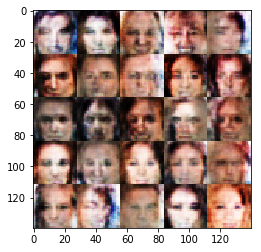

Epoch 1/1... Discriminator Loss: 1.2762... Generator Loss: 0.6712
Epoch 1/1... Discriminator Loss: 0.8983... Generator Loss: 1.3664
Epoch 1/1... Discriminator Loss: 1.1306... Generator Loss: 1.2090
Epoch 1/1... Discriminator Loss: 1.1960... Generator Loss: 0.7165
Epoch 1/1... Discriminator Loss: 1.0888... Generator Loss: 1.1146
Epoch 1/1... Discriminator Loss: 1.1272... Generator Loss: 0.7826
Epoch 1/1... Discriminator Loss: 1.3063... Generator Loss: 1.5180
Epoch 1/1... Discriminator Loss: 1.0213... Generator Loss: 1.1906
Epoch 1/1... Discriminator Loss: 1.2453... Generator Loss: 0.6951
Epoch 1/1... Discriminator Loss: 1.0682... Generator Loss: 0.9900


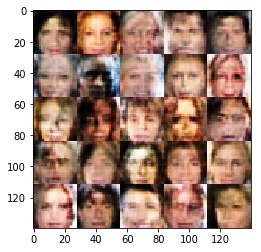

Epoch 1/1... Discriminator Loss: 1.1373... Generator Loss: 1.2697
Epoch 1/1... Discriminator Loss: 1.0855... Generator Loss: 0.9517
Epoch 1/1... Discriminator Loss: 1.0684... Generator Loss: 1.1853
Epoch 1/1... Discriminator Loss: 1.1209... Generator Loss: 0.8476
Epoch 1/1... Discriminator Loss: 0.9235... Generator Loss: 1.4344
Epoch 1/1... Discriminator Loss: 1.4188... Generator Loss: 0.4879
Epoch 1/1... Discriminator Loss: 1.0969... Generator Loss: 0.8553
Epoch 1/1... Discriminator Loss: 0.9992... Generator Loss: 0.9528
Epoch 1/1... Discriminator Loss: 0.9753... Generator Loss: 1.2674
Epoch 1/1... Discriminator Loss: 1.1058... Generator Loss: 1.3493


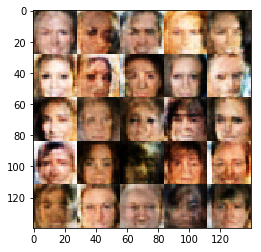

Epoch 1/1... Discriminator Loss: 1.1287... Generator Loss: 1.0099
Epoch 1/1... Discriminator Loss: 1.0775... Generator Loss: 0.9650
Epoch 1/1... Discriminator Loss: 1.0462... Generator Loss: 1.0462
Epoch 1/1... Discriminator Loss: 1.1374... Generator Loss: 1.3098
Epoch 1/1... Discriminator Loss: 1.0795... Generator Loss: 1.1163
Epoch 1/1... Discriminator Loss: 1.0713... Generator Loss: 1.2775
Epoch 1/1... Discriminator Loss: 1.0858... Generator Loss: 0.9681
Epoch 1/1... Discriminator Loss: 1.0592... Generator Loss: 0.9315
Epoch 1/1... Discriminator Loss: 1.1768... Generator Loss: 0.7018
Epoch 1/1... Discriminator Loss: 1.0804... Generator Loss: 1.0953


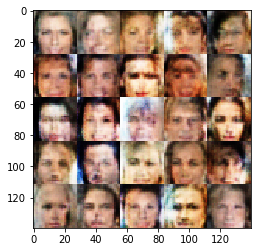

Epoch 1/1... Discriminator Loss: 1.1759... Generator Loss: 0.9496
Epoch 1/1... Discriminator Loss: 0.9489... Generator Loss: 1.1652
Epoch 1/1... Discriminator Loss: 1.0111... Generator Loss: 1.1542
Epoch 1/1... Discriminator Loss: 1.3581... Generator Loss: 0.5179
Epoch 1/1... Discriminator Loss: 0.9268... Generator Loss: 1.2191
Epoch 1/1... Discriminator Loss: 1.0676... Generator Loss: 0.8418
Epoch 1/1... Discriminator Loss: 1.0091... Generator Loss: 1.3029
Epoch 1/1... Discriminator Loss: 0.9895... Generator Loss: 1.9018
Epoch 1/1... Discriminator Loss: 0.9838... Generator Loss: 0.9766
Epoch 1/1... Discriminator Loss: 1.1870... Generator Loss: 0.7483


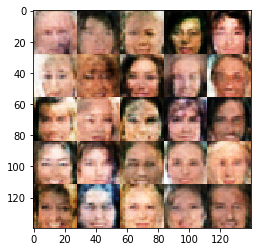

Epoch 1/1... Discriminator Loss: 1.2076... Generator Loss: 0.7566
Epoch 1/1... Discriminator Loss: 1.1883... Generator Loss: 0.6351
Epoch 1/1... Discriminator Loss: 1.0067... Generator Loss: 1.2272
Epoch 1/1... Discriminator Loss: 1.6255... Generator Loss: 0.3903
Epoch 1/1... Discriminator Loss: 1.0915... Generator Loss: 1.1348
Epoch 1/1... Discriminator Loss: 1.0579... Generator Loss: 0.9180
Epoch 1/1... Discriminator Loss: 1.0890... Generator Loss: 1.0255
Epoch 1/1... Discriminator Loss: 1.1285... Generator Loss: 0.8089
Epoch 1/1... Discriminator Loss: 1.0767... Generator Loss: 1.0268
Epoch 1/1... Discriminator Loss: 1.0626... Generator Loss: 0.8160


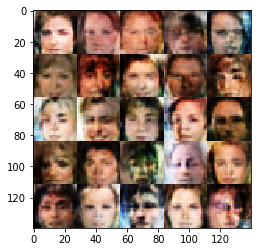

Epoch 1/1... Discriminator Loss: 1.0797... Generator Loss: 1.0904
Epoch 1/1... Discriminator Loss: 0.9776... Generator Loss: 0.9787
Epoch 1/1... Discriminator Loss: 0.9828... Generator Loss: 1.0016
Epoch 1/1... Discriminator Loss: 1.0465... Generator Loss: 1.0638
Epoch 1/1... Discriminator Loss: 1.2930... Generator Loss: 0.5589
Epoch 1/1... Discriminator Loss: 0.8716... Generator Loss: 1.3845
Epoch 1/1... Discriminator Loss: 1.2575... Generator Loss: 0.6310
Epoch 1/1... Discriminator Loss: 1.0277... Generator Loss: 0.8970
Epoch 1/1... Discriminator Loss: 1.3770... Generator Loss: 0.5931
Epoch 1/1... Discriminator Loss: 1.3234... Generator Loss: 0.9413


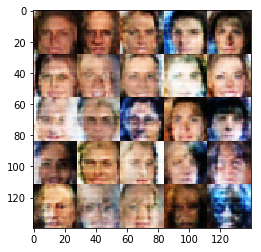

Epoch 1/1... Discriminator Loss: 1.1101... Generator Loss: 1.1795
Epoch 1/1... Discriminator Loss: 1.0279... Generator Loss: 0.9711
Epoch 1/1... Discriminator Loss: 0.9842... Generator Loss: 0.9718
Epoch 1/1... Discriminator Loss: 1.1674... Generator Loss: 0.8180
Epoch 1/1... Discriminator Loss: 1.0660... Generator Loss: 0.8049
Epoch 1/1... Discriminator Loss: 1.1466... Generator Loss: 1.0915
Epoch 1/1... Discriminator Loss: 1.3050... Generator Loss: 0.6295
Epoch 1/1... Discriminator Loss: 1.4783... Generator Loss: 0.4841
Epoch 1/1... Discriminator Loss: 1.0564... Generator Loss: 0.9254
Epoch 1/1... Discriminator Loss: 1.1201... Generator Loss: 0.7908


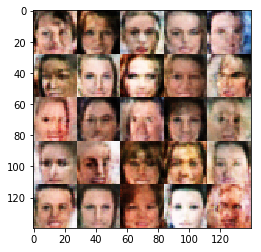

Epoch 1/1... Discriminator Loss: 1.2110... Generator Loss: 0.7041
Epoch 1/1... Discriminator Loss: 1.0632... Generator Loss: 0.8076
Epoch 1/1... Discriminator Loss: 1.1824... Generator Loss: 0.8609
Epoch 1/1... Discriminator Loss: 1.0183... Generator Loss: 0.9581
Epoch 1/1... Discriminator Loss: 1.3354... Generator Loss: 0.6425
Epoch 1/1... Discriminator Loss: 1.1118... Generator Loss: 0.7800
Epoch 1/1... Discriminator Loss: 1.0653... Generator Loss: 0.8489
Epoch 1/1... Discriminator Loss: 1.3613... Generator Loss: 0.5986
Epoch 1/1... Discriminator Loss: 0.9618... Generator Loss: 1.1780
Epoch 1/1... Discriminator Loss: 1.1113... Generator Loss: 0.9023


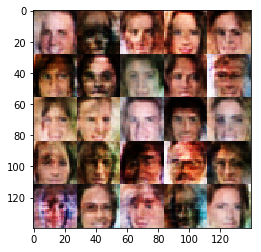

Epoch 1/1... Discriminator Loss: 1.0536... Generator Loss: 1.1845
Epoch 1/1... Discriminator Loss: 1.0553... Generator Loss: 1.0331
Epoch 1/1... Discriminator Loss: 0.9149... Generator Loss: 1.1703
Epoch 1/1... Discriminator Loss: 1.1049... Generator Loss: 0.8516
Epoch 1/1... Discriminator Loss: 0.9748... Generator Loss: 1.1448
Epoch 1/1... Discriminator Loss: 1.0314... Generator Loss: 1.2822
Epoch 1/1... Discriminator Loss: 0.9586... Generator Loss: 1.2045
Epoch 1/1... Discriminator Loss: 0.8949... Generator Loss: 1.1250
Epoch 1/1... Discriminator Loss: 1.4516... Generator Loss: 0.4851
Epoch 1/1... Discriminator Loss: 1.4644... Generator Loss: 1.9836


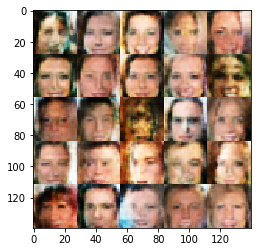

Epoch 1/1... Discriminator Loss: 1.0649... Generator Loss: 1.5277
Epoch 1/1... Discriminator Loss: 1.1172... Generator Loss: 0.8448
Epoch 1/1... Discriminator Loss: 1.0331... Generator Loss: 1.0398
Epoch 1/1... Discriminator Loss: 1.0151... Generator Loss: 0.9053
Epoch 1/1... Discriminator Loss: 1.2319... Generator Loss: 0.7019
Epoch 1/1... Discriminator Loss: 1.3172... Generator Loss: 0.6542
Epoch 1/1... Discriminator Loss: 0.9433... Generator Loss: 1.5070
Epoch 1/1... Discriminator Loss: 1.0267... Generator Loss: 1.0512
Epoch 1/1... Discriminator Loss: 1.0108... Generator Loss: 0.9642
Epoch 1/1... Discriminator Loss: 1.1910... Generator Loss: 1.4375


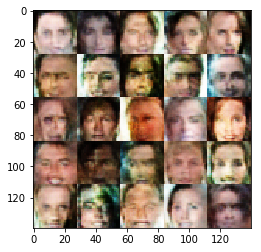

Epoch 1/1... Discriminator Loss: 0.9995... Generator Loss: 1.1633
Epoch 1/1... Discriminator Loss: 1.0952... Generator Loss: 0.9002
Epoch 1/1... Discriminator Loss: 1.0391... Generator Loss: 1.2537
Epoch 1/1... Discriminator Loss: 1.1467... Generator Loss: 0.7156
Epoch 1/1... Discriminator Loss: 0.9478... Generator Loss: 1.1143
Epoch 1/1... Discriminator Loss: 1.0968... Generator Loss: 1.3260
Epoch 1/1... Discriminator Loss: 0.9952... Generator Loss: 1.2561
Epoch 1/1... Discriminator Loss: 1.1635... Generator Loss: 0.7140
Epoch 1/1... Discriminator Loss: 1.1672... Generator Loss: 0.9966
Epoch 1/1... Discriminator Loss: 1.1569... Generator Loss: 0.9322


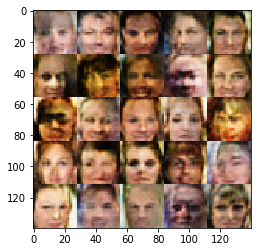

Epoch 1/1... Discriminator Loss: 1.1541... Generator Loss: 0.7158
Epoch 1/1... Discriminator Loss: 1.3805... Generator Loss: 0.6776
Epoch 1/1... Discriminator Loss: 0.8837... Generator Loss: 1.1960
Epoch 1/1... Discriminator Loss: 0.7918... Generator Loss: 1.5635
Epoch 1/1... Discriminator Loss: 1.1830... Generator Loss: 0.8092
Epoch 1/1... Discriminator Loss: 1.2183... Generator Loss: 0.6699
Epoch 1/1... Discriminator Loss: 0.9197... Generator Loss: 1.3991
Epoch 1/1... Discriminator Loss: 1.3161... Generator Loss: 0.5286
Epoch 1/1... Discriminator Loss: 1.1711... Generator Loss: 1.2968
Epoch 1/1... Discriminator Loss: 1.0724... Generator Loss: 0.9704


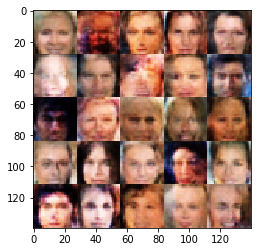

Epoch 1/1... Discriminator Loss: 0.9604... Generator Loss: 1.2444
Epoch 1/1... Discriminator Loss: 1.0126... Generator Loss: 0.9308
Epoch 1/1... Discriminator Loss: 0.9687... Generator Loss: 0.9258
Epoch 1/1... Discriminator Loss: 1.0868... Generator Loss: 0.9659
Epoch 1/1... Discriminator Loss: 1.1008... Generator Loss: 0.8751
Epoch 1/1... Discriminator Loss: 1.3446... Generator Loss: 0.7334
Epoch 1/1... Discriminator Loss: 0.8763... Generator Loss: 1.0938
Epoch 1/1... Discriminator Loss: 0.8349... Generator Loss: 1.1406
Epoch 1/1... Discriminator Loss: 0.8357... Generator Loss: 1.2354
Epoch 1/1... Discriminator Loss: 1.1243... Generator Loss: 0.8442


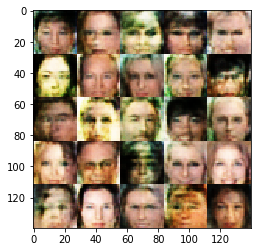

Epoch 1/1... Discriminator Loss: 1.2797... Generator Loss: 0.6170
Epoch 1/1... Discriminator Loss: 0.9754... Generator Loss: 0.9583
Epoch 1/1... Discriminator Loss: 1.0047... Generator Loss: 0.9421
Epoch 1/1... Discriminator Loss: 0.9900... Generator Loss: 0.9924
Epoch 1/1... Discriminator Loss: 0.9481... Generator Loss: 1.2757
Epoch 1/1... Discriminator Loss: 0.9708... Generator Loss: 0.9210
Epoch 1/1... Discriminator Loss: 1.0720... Generator Loss: 0.8450
Epoch 1/1... Discriminator Loss: 1.1413... Generator Loss: 0.9241
Epoch 1/1... Discriminator Loss: 0.9605... Generator Loss: 1.3089
Epoch 1/1... Discriminator Loss: 0.9254... Generator Loss: 1.0240


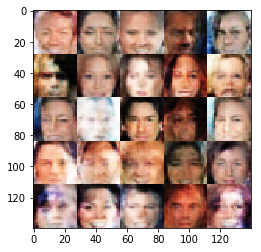

Epoch 1/1... Discriminator Loss: 1.0201... Generator Loss: 1.4157
Epoch 1/1... Discriminator Loss: 0.8395... Generator Loss: 1.3448
Epoch 1/1... Discriminator Loss: 0.8154... Generator Loss: 1.3876
Epoch 1/1... Discriminator Loss: 1.0544... Generator Loss: 0.8125
Epoch 1/1... Discriminator Loss: 1.2967... Generator Loss: 0.7694
Epoch 1/1... Discriminator Loss: 0.9029... Generator Loss: 1.4405
Epoch 1/1... Discriminator Loss: 1.1303... Generator Loss: 0.8377
Epoch 1/1... Discriminator Loss: 0.9291... Generator Loss: 1.1026
Epoch 1/1... Discriminator Loss: 1.3180... Generator Loss: 0.5640
Epoch 1/1... Discriminator Loss: 1.0437... Generator Loss: 0.8089


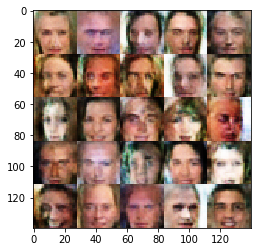

Epoch 1/1... Discriminator Loss: 0.9845... Generator Loss: 1.0318
Epoch 1/1... Discriminator Loss: 0.9600... Generator Loss: 1.0971
Epoch 1/1... Discriminator Loss: 0.8512... Generator Loss: 1.1358
Epoch 1/1... Discriminator Loss: 1.1178... Generator Loss: 0.7813
Epoch 1/1... Discriminator Loss: 1.2513... Generator Loss: 0.6292
Epoch 1/1... Discriminator Loss: 1.1897... Generator Loss: 0.6961
Epoch 1/1... Discriminator Loss: 1.2251... Generator Loss: 0.6638
Epoch 1/1... Discriminator Loss: 0.9443... Generator Loss: 0.9622
Epoch 1/1... Discriminator Loss: 0.8705... Generator Loss: 1.2354
Epoch 1/1... Discriminator Loss: 1.2057... Generator Loss: 1.1471


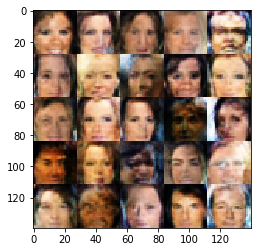

Epoch 1/1... Discriminator Loss: 1.2167... Generator Loss: 0.6983
Epoch 1/1... Discriminator Loss: 1.0656... Generator Loss: 1.0669
Epoch 1/1... Discriminator Loss: 0.9362... Generator Loss: 1.9064
Epoch 1/1... Discriminator Loss: 0.9727... Generator Loss: 1.4078
Epoch 1/1... Discriminator Loss: 1.2250... Generator Loss: 0.7268
Epoch 1/1... Discriminator Loss: 0.8973... Generator Loss: 1.2416
Epoch 1/1... Discriminator Loss: 1.2508... Generator Loss: 0.6366
Epoch 1/1... Discriminator Loss: 1.4347... Generator Loss: 0.7117
Epoch 1/1... Discriminator Loss: 0.8683... Generator Loss: 1.0866
Epoch 1/1... Discriminator Loss: 1.1545... Generator Loss: 0.7084


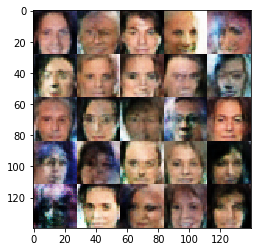

Epoch 1/1... Discriminator Loss: 1.2413... Generator Loss: 0.7415
Epoch 1/1... Discriminator Loss: 1.2079... Generator Loss: 0.9293
Epoch 1/1... Discriminator Loss: 1.3617... Generator Loss: 1.0180
Epoch 1/1... Discriminator Loss: 0.9700... Generator Loss: 0.9927
Epoch 1/1... Discriminator Loss: 0.9920... Generator Loss: 0.8995
Epoch 1/1... Discriminator Loss: 1.1412... Generator Loss: 0.6858
Epoch 1/1... Discriminator Loss: 0.7708... Generator Loss: 1.2396
Epoch 1/1... Discriminator Loss: 1.5737... Generator Loss: 0.4007
Epoch 1/1... Discriminator Loss: 1.1738... Generator Loss: 0.8150
Epoch 1/1... Discriminator Loss: 0.9595... Generator Loss: 0.9612


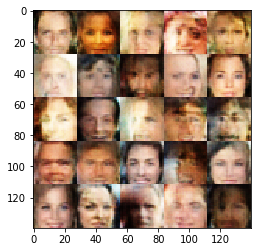

Epoch 1/1... Discriminator Loss: 1.0587... Generator Loss: 1.3884
Epoch 1/1... Discriminator Loss: 1.1737... Generator Loss: 1.0530
Epoch 1/1... Discriminator Loss: 1.0970... Generator Loss: 2.0585
Epoch 1/1... Discriminator Loss: 1.0499... Generator Loss: 1.1088
Epoch 1/1... Discriminator Loss: 1.3430... Generator Loss: 0.6083
Epoch 1/1... Discriminator Loss: 1.6953... Generator Loss: 0.3491
Epoch 1/1... Discriminator Loss: 1.0532... Generator Loss: 0.8709
Epoch 1/1... Discriminator Loss: 0.6294... Generator Loss: 2.0545
Epoch 1/1... Discriminator Loss: 1.4308... Generator Loss: 0.9480
Epoch 1/1... Discriminator Loss: 1.2269... Generator Loss: 0.7321


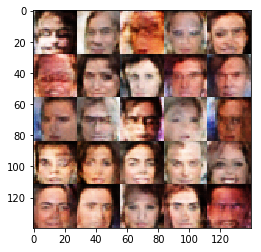

Epoch 1/1... Discriminator Loss: 1.0592... Generator Loss: 0.8402
Epoch 1/1... Discriminator Loss: 0.9496... Generator Loss: 1.0308
Epoch 1/1... Discriminator Loss: 1.2249... Generator Loss: 0.6168
Epoch 1/1... Discriminator Loss: 1.4039... Generator Loss: 0.4853
Epoch 1/1... Discriminator Loss: 1.0890... Generator Loss: 0.8605
Epoch 1/1... Discriminator Loss: 0.9922... Generator Loss: 1.2345
Epoch 1/1... Discriminator Loss: 1.4166... Generator Loss: 0.6518
Epoch 1/1... Discriminator Loss: 0.8732... Generator Loss: 1.1487
Epoch 1/1... Discriminator Loss: 1.3752... Generator Loss: 0.5138
Epoch 1/1... Discriminator Loss: 1.3161... Generator Loss: 0.6147


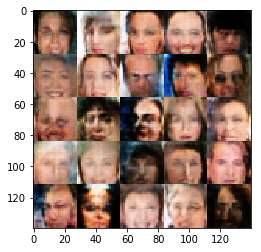

Epoch 1/1... Discriminator Loss: 1.1230... Generator Loss: 0.7581
Epoch 1/1... Discriminator Loss: 0.9548... Generator Loss: 1.3268
Epoch 1/1... Discriminator Loss: 0.9895... Generator Loss: 0.9841
Epoch 1/1... Discriminator Loss: 1.5940... Generator Loss: 0.5010
Epoch 1/1... Discriminator Loss: 0.9560... Generator Loss: 1.0964
Epoch 1/1... Discriminator Loss: 1.1897... Generator Loss: 0.7812
Epoch 1/1... Discriminator Loss: 1.1562... Generator Loss: 0.7087
Epoch 1/1... Discriminator Loss: 0.8937... Generator Loss: 1.0309
Epoch 1/1... Discriminator Loss: 0.9738... Generator Loss: 1.0160
Epoch 1/1... Discriminator Loss: 0.8991... Generator Loss: 1.2603


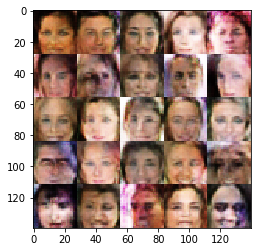

Epoch 1/1... Discriminator Loss: 1.1340... Generator Loss: 0.8341
Epoch 1/1... Discriminator Loss: 1.1766... Generator Loss: 0.7965
Epoch 1/1... Discriminator Loss: 1.0997... Generator Loss: 0.8416
Epoch 1/1... Discriminator Loss: 1.2309... Generator Loss: 0.7662
Epoch 1/1... Discriminator Loss: 1.1207... Generator Loss: 0.8394
Epoch 1/1... Discriminator Loss: 0.9366... Generator Loss: 1.1044
Epoch 1/1... Discriminator Loss: 0.9612... Generator Loss: 0.9681
Epoch 1/1... Discriminator Loss: 0.9729... Generator Loss: 0.9307
Epoch 1/1... Discriminator Loss: 1.0751... Generator Loss: 1.3988
Epoch 1/1... Discriminator Loss: 1.1809... Generator Loss: 0.6835


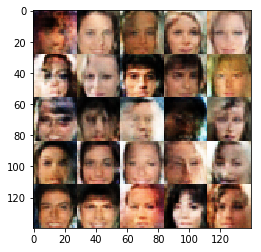

Epoch 1/1... Discriminator Loss: 1.0974... Generator Loss: 1.0274
Epoch 1/1... Discriminator Loss: 0.8793... Generator Loss: 1.5483
Epoch 1/1... Discriminator Loss: 1.0467... Generator Loss: 1.7103
Epoch 1/1... Discriminator Loss: 0.9559... Generator Loss: 1.1507
Epoch 1/1... Discriminator Loss: 1.1886... Generator Loss: 0.8133
Epoch 1/1... Discriminator Loss: 0.8234... Generator Loss: 1.3256
Epoch 1/1... Discriminator Loss: 1.0534... Generator Loss: 0.8777
Epoch 1/1... Discriminator Loss: 1.2508... Generator Loss: 0.6467
Epoch 1/1... Discriminator Loss: 1.0772... Generator Loss: 0.8156
Epoch 1/1... Discriminator Loss: 1.1155... Generator Loss: 0.7978


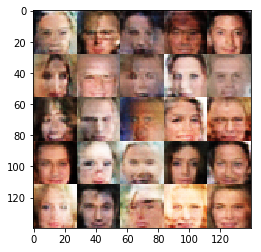

Epoch 1/1... Discriminator Loss: 1.1430... Generator Loss: 0.8122
Epoch 1/1... Discriminator Loss: 1.1162... Generator Loss: 0.8350
Epoch 1/1... Discriminator Loss: 0.9484... Generator Loss: 1.1771
Epoch 1/1... Discriminator Loss: 0.7676... Generator Loss: 1.4944
Epoch 1/1... Discriminator Loss: 0.9586... Generator Loss: 1.0455
Epoch 1/1... Discriminator Loss: 1.1804... Generator Loss: 0.7339
Epoch 1/1... Discriminator Loss: 0.9745... Generator Loss: 1.0185
Epoch 1/1... Discriminator Loss: 1.0328... Generator Loss: 0.8535
Epoch 1/1... Discriminator Loss: 0.9815... Generator Loss: 1.4289
Epoch 1/1... Discriminator Loss: 0.8688... Generator Loss: 1.5279


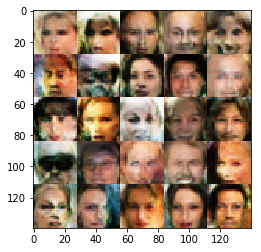

Epoch 1/1... Discriminator Loss: 1.0737... Generator Loss: 0.7906
Epoch 1/1... Discriminator Loss: 1.3335... Generator Loss: 0.5305
Epoch 1/1... Discriminator Loss: 1.1827... Generator Loss: 0.6403
Epoch 1/1... Discriminator Loss: 1.3778... Generator Loss: 0.4872
Epoch 1/1... Discriminator Loss: 1.0891... Generator Loss: 0.8249
Epoch 1/1... Discriminator Loss: 0.8837... Generator Loss: 1.4433
Epoch 1/1... Discriminator Loss: 1.2002... Generator Loss: 0.7417
Epoch 1/1... Discriminator Loss: 1.0253... Generator Loss: 1.0944
Epoch 1/1... Discriminator Loss: 0.9355... Generator Loss: 1.0441
Epoch 1/1... Discriminator Loss: 0.8104... Generator Loss: 1.2472


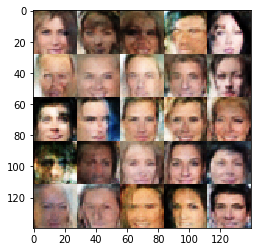

Epoch 1/1... Discriminator Loss: 1.4821... Generator Loss: 0.4441
Epoch 1/1... Discriminator Loss: 0.9423... Generator Loss: 1.0701
Epoch 1/1... Discriminator Loss: 1.8155... Generator Loss: 0.3287
Epoch 1/1... Discriminator Loss: 1.3893... Generator Loss: 0.6546
Epoch 1/1... Discriminator Loss: 1.0802... Generator Loss: 1.0874
Epoch 1/1... Discriminator Loss: 0.9526... Generator Loss: 1.2028
Epoch 1/1... Discriminator Loss: 1.1211... Generator Loss: 0.8944
Epoch 1/1... Discriminator Loss: 0.7179... Generator Loss: 1.4218
Epoch 1/1... Discriminator Loss: 1.1937... Generator Loss: 0.6715
Epoch 1/1... Discriminator Loss: 0.8822... Generator Loss: 1.1001


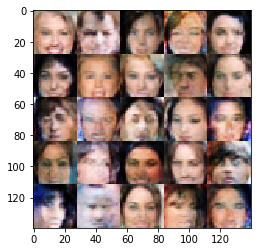

Epoch 1/1... Discriminator Loss: 1.0463... Generator Loss: 1.0631
Epoch 1/1... Discriminator Loss: 0.8773... Generator Loss: 1.1919
Epoch 1/1... Discriminator Loss: 1.0401... Generator Loss: 1.0173
Epoch 1/1... Discriminator Loss: 1.1634... Generator Loss: 0.7619
Epoch 1/1... Discriminator Loss: 0.9617... Generator Loss: 1.2959
Epoch 1/1... Discriminator Loss: 1.3376... Generator Loss: 0.8152
Epoch 1/1... Discriminator Loss: 0.7987... Generator Loss: 1.3849
Epoch 1/1... Discriminator Loss: 1.6288... Generator Loss: 0.3758
Epoch 1/1... Discriminator Loss: 1.2020... Generator Loss: 0.7665
Epoch 1/1... Discriminator Loss: 1.2365... Generator Loss: 0.6092


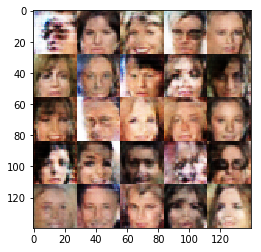

Epoch 1/1... Discriminator Loss: 1.1496... Generator Loss: 0.7399
Epoch 1/1... Discriminator Loss: 1.0169... Generator Loss: 0.9614
Epoch 1/1... Discriminator Loss: 1.0924... Generator Loss: 0.7593
Epoch 1/1... Discriminator Loss: 1.1299... Generator Loss: 0.9034
Epoch 1/1... Discriminator Loss: 1.1201... Generator Loss: 0.8100
Epoch 1/1... Discriminator Loss: 0.9266... Generator Loss: 1.1251
Epoch 1/1... Discriminator Loss: 1.0837... Generator Loss: 0.9080
Epoch 1/1... Discriminator Loss: 1.3704... Generator Loss: 0.5559
Epoch 1/1... Discriminator Loss: 1.1032... Generator Loss: 0.8579
Epoch 1/1... Discriminator Loss: 1.1831... Generator Loss: 0.7331


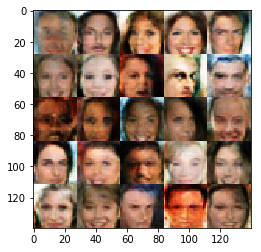

Epoch 1/1... Discriminator Loss: 0.9749... Generator Loss: 1.4276
Epoch 1/1... Discriminator Loss: 1.1204... Generator Loss: 0.8278
Epoch 1/1... Discriminator Loss: 1.0128... Generator Loss: 1.0146
Epoch 1/1... Discriminator Loss: 0.8752... Generator Loss: 1.4041
Epoch 1/1... Discriminator Loss: 2.0206... Generator Loss: 0.2398
Epoch 1/1... Discriminator Loss: 1.0380... Generator Loss: 0.9591
Epoch 1/1... Discriminator Loss: 0.9352... Generator Loss: 1.0288
Epoch 1/1... Discriminator Loss: 0.9194... Generator Loss: 0.9707
Epoch 1/1... Discriminator Loss: 1.0283... Generator Loss: 1.5082
Epoch 1/1... Discriminator Loss: 1.4749... Generator Loss: 0.4594


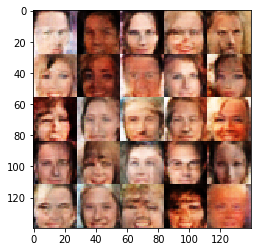

Epoch 1/1... Discriminator Loss: 1.0816... Generator Loss: 1.0206
Epoch 1/1... Discriminator Loss: 0.9476... Generator Loss: 0.9326
Epoch 1/1... Discriminator Loss: 1.3005... Generator Loss: 0.6251
Epoch 1/1... Discriminator Loss: 1.0798... Generator Loss: 1.3291
Epoch 1/1... Discriminator Loss: 1.1182... Generator Loss: 0.9106
Epoch 1/1... Discriminator Loss: 0.7009... Generator Loss: 1.4706
Epoch 1/1... Discriminator Loss: 1.1894... Generator Loss: 0.6879
Epoch 1/1... Discriminator Loss: 0.9010... Generator Loss: 1.2682
Epoch 1/1... Discriminator Loss: 1.0075... Generator Loss: 1.2849
Epoch 1/1... Discriminator Loss: 1.0903... Generator Loss: 0.7800


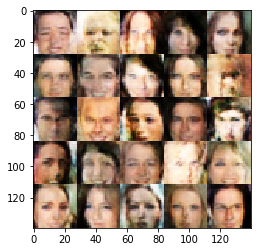

Epoch 1/1... Discriminator Loss: 1.6536... Generator Loss: 0.3833
Epoch 1/1... Discriminator Loss: 1.0142... Generator Loss: 0.8927
Epoch 1/1... Discriminator Loss: 1.1278... Generator Loss: 0.8453
Epoch 1/1... Discriminator Loss: 0.7402... Generator Loss: 1.3269
Epoch 1/1... Discriminator Loss: 1.3148... Generator Loss: 0.5985
Epoch 1/1... Discriminator Loss: 1.2470... Generator Loss: 0.6963
Epoch 1/1... Discriminator Loss: 1.2449... Generator Loss: 1.0899
Epoch 1/1... Discriminator Loss: 1.0253... Generator Loss: 0.9263
Epoch 1/1... Discriminator Loss: 1.5164... Generator Loss: 0.4767
Epoch 1/1... Discriminator Loss: 1.0087... Generator Loss: 1.1797


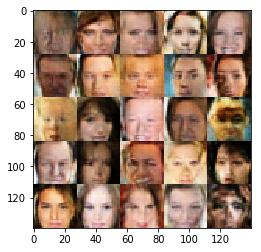

Epoch 1/1... Discriminator Loss: 1.3895... Generator Loss: 0.4931
Epoch 1/1... Discriminator Loss: 1.1060... Generator Loss: 0.8407
Epoch 1/1... Discriminator Loss: 1.4459... Generator Loss: 0.5472
Epoch 1/1... Discriminator Loss: 0.9060... Generator Loss: 1.1723
Epoch 1/1... Discriminator Loss: 0.9965... Generator Loss: 0.9530
Epoch 1/1... Discriminator Loss: 0.8881... Generator Loss: 1.3725
Epoch 1/1... Discriminator Loss: 1.3227... Generator Loss: 0.6801
Epoch 1/1... Discriminator Loss: 1.1501... Generator Loss: 0.8775
Epoch 1/1... Discriminator Loss: 0.9272... Generator Loss: 1.4270
Epoch 1/1... Discriminator Loss: 1.1265... Generator Loss: 0.8942


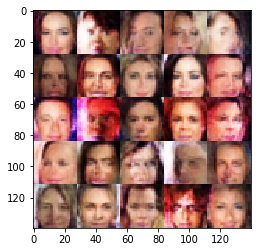

Epoch 1/1... Discriminator Loss: 1.0807... Generator Loss: 0.9832
Epoch 1/1... Discriminator Loss: 1.2918... Generator Loss: 0.6351
Epoch 1/1... Discriminator Loss: 1.0937... Generator Loss: 1.2020
Epoch 1/1... Discriminator Loss: 1.0433... Generator Loss: 0.9506
Epoch 1/1... Discriminator Loss: 1.1678... Generator Loss: 0.8102
Epoch 1/1... Discriminator Loss: 1.3943... Generator Loss: 0.5807
Epoch 1/1... Discriminator Loss: 1.1275... Generator Loss: 0.9316
Epoch 1/1... Discriminator Loss: 1.1999... Generator Loss: 0.9340
Epoch 1/1... Discriminator Loss: 0.9534... Generator Loss: 1.6399
Epoch 1/1... Discriminator Loss: 1.2332... Generator Loss: 0.6934


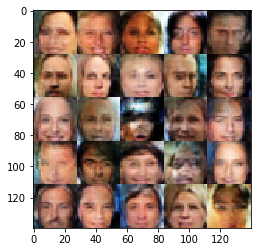

Epoch 1/1... Discriminator Loss: 1.4632... Generator Loss: 0.4879
Epoch 1/1... Discriminator Loss: 1.0354... Generator Loss: 0.9763
Epoch 1/1... Discriminator Loss: 1.0834... Generator Loss: 1.1866
Epoch 1/1... Discriminator Loss: 1.1910... Generator Loss: 0.6814
Epoch 1/1... Discriminator Loss: 1.2590... Generator Loss: 0.6178
Epoch 1/1... Discriminator Loss: 1.1293... Generator Loss: 0.8160
Epoch 1/1... Discriminator Loss: 0.8947... Generator Loss: 1.2963
Epoch 1/1... Discriminator Loss: 1.1580... Generator Loss: 0.6813
Epoch 1/1... Discriminator Loss: 0.9942... Generator Loss: 0.9012
Epoch 1/1... Discriminator Loss: 1.2260... Generator Loss: 0.8534


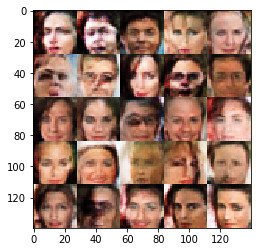

Epoch 1/1... Discriminator Loss: 1.2483... Generator Loss: 0.6738
Epoch 1/1... Discriminator Loss: 1.1207... Generator Loss: 0.7187
Epoch 1/1... Discriminator Loss: 0.9245... Generator Loss: 1.0725
Epoch 1/1... Discriminator Loss: 0.9924... Generator Loss: 0.9846
Epoch 1/1... Discriminator Loss: 1.0182... Generator Loss: 0.8779
Epoch 1/1... Discriminator Loss: 0.7640... Generator Loss: 1.5257
Epoch 1/1... Discriminator Loss: 1.3183... Generator Loss: 0.6098
Epoch 1/1... Discriminator Loss: 1.3693... Generator Loss: 0.5526
Epoch 1/1... Discriminator Loss: 1.2777... Generator Loss: 0.6046
Epoch 1/1... Discriminator Loss: 1.0546... Generator Loss: 1.4869


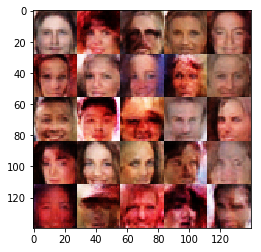

Epoch 1/1... Discriminator Loss: 0.6673... Generator Loss: 1.4520
Epoch 1/1... Discriminator Loss: 1.1501... Generator Loss: 0.7122
Epoch 1/1... Discriminator Loss: 1.2267... Generator Loss: 0.6915
Epoch 1/1... Discriminator Loss: 1.1822... Generator Loss: 0.7627
Epoch 1/1... Discriminator Loss: 0.9528... Generator Loss: 1.2106
Epoch 1/1... Discriminator Loss: 1.0860... Generator Loss: 0.8491
Epoch 1/1... Discriminator Loss: 0.9402... Generator Loss: 1.3590
Epoch 1/1... Discriminator Loss: 0.9895... Generator Loss: 0.9447
Epoch 1/1... Discriminator Loss: 1.0636... Generator Loss: 0.8853
Epoch 1/1... Discriminator Loss: 1.0468... Generator Loss: 0.7724


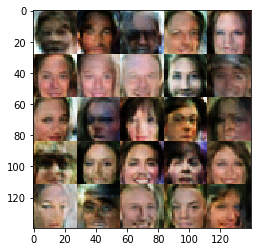

Epoch 1/1... Discriminator Loss: 1.1227... Generator Loss: 0.7506
Epoch 1/1... Discriminator Loss: 1.1701... Generator Loss: 0.6585
Epoch 1/1... Discriminator Loss: 1.1863... Generator Loss: 0.7050
Epoch 1/1... Discriminator Loss: 1.4510... Generator Loss: 0.4826
Epoch 1/1... Discriminator Loss: 1.1873... Generator Loss: 0.7190
Epoch 1/1... Discriminator Loss: 1.2578... Generator Loss: 0.6059
Epoch 1/1... Discriminator Loss: 1.2678... Generator Loss: 0.7855
Epoch 1/1... Discriminator Loss: 0.9734... Generator Loss: 1.2652
Epoch 1/1... Discriminator Loss: 1.0991... Generator Loss: 0.7654
Epoch 1/1... Discriminator Loss: 0.9267... Generator Loss: 1.1276


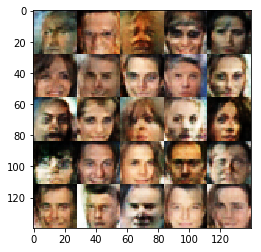

Epoch 1/1... Discriminator Loss: 1.1622... Generator Loss: 0.7152
Epoch 1/1... Discriminator Loss: 0.8988... Generator Loss: 1.4202
Epoch 1/1... Discriminator Loss: 1.0432... Generator Loss: 0.9526
Epoch 1/1... Discriminator Loss: 0.9033... Generator Loss: 1.2205
Epoch 1/1... Discriminator Loss: 1.0016... Generator Loss: 1.0597
Epoch 1/1... Discriminator Loss: 1.1420... Generator Loss: 0.7151
Epoch 1/1... Discriminator Loss: 1.2194... Generator Loss: 0.6756
Epoch 1/1... Discriminator Loss: 1.1672... Generator Loss: 0.8641
Epoch 1/1... Discriminator Loss: 1.1192... Generator Loss: 0.8824
Epoch 1/1... Discriminator Loss: 0.9634... Generator Loss: 0.9630


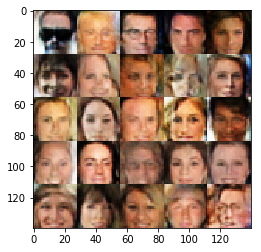

Epoch 1/1... Discriminator Loss: 1.2309... Generator Loss: 0.7107
Epoch 1/1... Discriminator Loss: 0.9680... Generator Loss: 0.9203
Epoch 1/1... Discriminator Loss: 1.1671... Generator Loss: 0.7428
Epoch 1/1... Discriminator Loss: 1.1107... Generator Loss: 0.7659
Epoch 1/1... Discriminator Loss: 0.8272... Generator Loss: 1.3202
Epoch 1/1... Discriminator Loss: 1.2333... Generator Loss: 0.7173
Epoch 1/1... Discriminator Loss: 1.0937... Generator Loss: 0.9254
Epoch 1/1... Discriminator Loss: 0.9339... Generator Loss: 1.5025
Epoch 1/1... Discriminator Loss: 1.2014... Generator Loss: 0.6442
Epoch 1/1... Discriminator Loss: 1.6058... Generator Loss: 0.4422


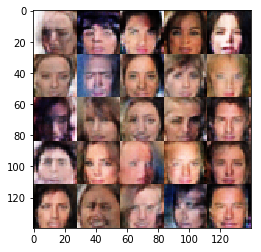

Epoch 1/1... Discriminator Loss: 1.2045... Generator Loss: 0.7571
Epoch 1/1... Discriminator Loss: 1.3022... Generator Loss: 1.1105
Epoch 1/1... Discriminator Loss: 1.4529... Generator Loss: 0.4740
Epoch 1/1... Discriminator Loss: 1.2355... Generator Loss: 0.7133
Epoch 1/1... Discriminator Loss: 1.0760... Generator Loss: 0.8342
Epoch 1/1... Discriminator Loss: 1.0808... Generator Loss: 0.7838
Epoch 1/1... Discriminator Loss: 0.8402... Generator Loss: 1.2428
Epoch 1/1... Discriminator Loss: 1.1493... Generator Loss: 0.7613
Epoch 1/1... Discriminator Loss: 1.0220... Generator Loss: 0.9676
Epoch 1/1... Discriminator Loss: 1.0396... Generator Loss: 1.2457


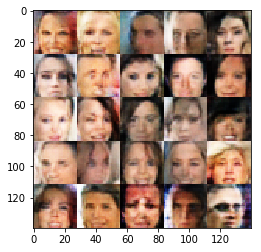

Epoch 1/1... Discriminator Loss: 1.2277... Generator Loss: 1.5891
Epoch 1/1... Discriminator Loss: 1.1138... Generator Loss: 0.9006
Epoch 1/1... Discriminator Loss: 1.1385... Generator Loss: 0.7633
Epoch 1/1... Discriminator Loss: 1.0042... Generator Loss: 0.9731
Epoch 1/1... Discriminator Loss: 1.1568... Generator Loss: 1.0351
Epoch 1/1... Discriminator Loss: 1.0857... Generator Loss: 0.9314
Epoch 1/1... Discriminator Loss: 1.2822... Generator Loss: 0.5806
Epoch 1/1... Discriminator Loss: 1.1627... Generator Loss: 0.7306
Epoch 1/1... Discriminator Loss: 1.3367... Generator Loss: 0.5436
Epoch 1/1... Discriminator Loss: 1.0815... Generator Loss: 0.8643


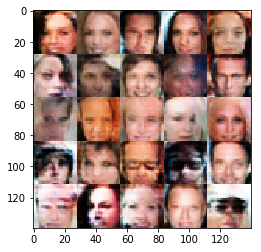

Epoch 1/1... Discriminator Loss: 0.9746... Generator Loss: 1.3681
Epoch 1/1... Discriminator Loss: 1.3002... Generator Loss: 0.5539
Epoch 1/1... Discriminator Loss: 1.0543... Generator Loss: 1.1552
Epoch 1/1... Discriminator Loss: 1.0894... Generator Loss: 0.9430
Epoch 1/1... Discriminator Loss: 1.0371... Generator Loss: 1.4621
Epoch 1/1... Discriminator Loss: 1.1795... Generator Loss: 0.7393
Epoch 1/1... Discriminator Loss: 0.8614... Generator Loss: 1.3189
Epoch 1/1... Discriminator Loss: 0.8245... Generator Loss: 1.1886
Epoch 1/1... Discriminator Loss: 0.9685... Generator Loss: 1.0189
Epoch 1/1... Discriminator Loss: 1.0030... Generator Loss: 1.0194


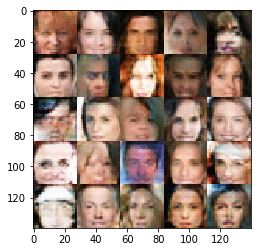

Epoch 1/1... Discriminator Loss: 0.8606... Generator Loss: 1.1142
Epoch 1/1... Discriminator Loss: 1.1629... Generator Loss: 0.7187
Epoch 1/1... Discriminator Loss: 1.0211... Generator Loss: 1.0558
Epoch 1/1... Discriminator Loss: 0.9609... Generator Loss: 1.0148
Epoch 1/1... Discriminator Loss: 0.9856... Generator Loss: 1.1920
Epoch 1/1... Discriminator Loss: 0.8988... Generator Loss: 1.0931
Epoch 1/1... Discriminator Loss: 1.3682... Generator Loss: 0.6600
Epoch 1/1... Discriminator Loss: 1.0871... Generator Loss: 0.7671
Epoch 1/1... Discriminator Loss: 0.9781... Generator Loss: 1.4051
Epoch 1/1... Discriminator Loss: 1.4151... Generator Loss: 0.6807


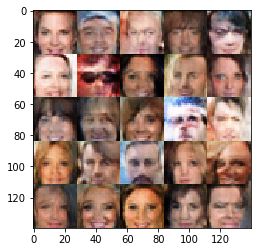

Epoch 1/1... Discriminator Loss: 0.9453... Generator Loss: 0.9947
Epoch 1/1... Discriminator Loss: 0.7946... Generator Loss: 1.3789
Epoch 1/1... Discriminator Loss: 1.2394... Generator Loss: 0.6055
Epoch 1/1... Discriminator Loss: 1.0508... Generator Loss: 0.9999
Epoch 1/1... Discriminator Loss: 1.1897... Generator Loss: 0.7268
Epoch 1/1... Discriminator Loss: 1.2385... Generator Loss: 0.6014
Epoch 1/1... Discriminator Loss: 0.9665... Generator Loss: 1.0156
Epoch 1/1... Discriminator Loss: 0.9473... Generator Loss: 0.9402
Epoch 1/1... Discriminator Loss: 1.1299... Generator Loss: 0.7366
Epoch 1/1... Discriminator Loss: 1.4396... Generator Loss: 0.5649


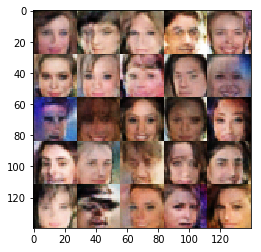

Epoch 1/1... Discriminator Loss: 1.2498... Generator Loss: 0.6403
Epoch 1/1... Discriminator Loss: 1.5648... Generator Loss: 0.3960
Epoch 1/1... Discriminator Loss: 1.1837... Generator Loss: 0.6914
Epoch 1/1... Discriminator Loss: 1.0756... Generator Loss: 0.9244
Epoch 1/1... Discriminator Loss: 1.1178... Generator Loss: 0.6793
Epoch 1/1... Discriminator Loss: 1.0646... Generator Loss: 0.8463
Epoch 1/1... Discriminator Loss: 1.0877... Generator Loss: 0.9524
Epoch 1/1... Discriminator Loss: 1.0732... Generator Loss: 0.8034
Epoch 1/1... Discriminator Loss: 1.2591... Generator Loss: 0.5911
Epoch 1/1... Discriminator Loss: 1.0320... Generator Loss: 0.8703


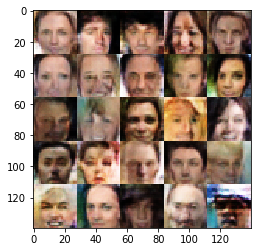

Epoch 1/1... Discriminator Loss: 0.8500... Generator Loss: 1.2482
Epoch 1/1... Discriminator Loss: 1.0885... Generator Loss: 0.9135
Epoch 1/1... Discriminator Loss: 1.0216... Generator Loss: 1.0178
Epoch 1/1... Discriminator Loss: 1.1169... Generator Loss: 0.8111
Epoch 1/1... Discriminator Loss: 1.3093... Generator Loss: 0.5408
Epoch 1/1... Discriminator Loss: 0.9774... Generator Loss: 1.2005
Epoch 1/1... Discriminator Loss: 1.2843... Generator Loss: 0.6060
Epoch 1/1... Discriminator Loss: 0.8404... Generator Loss: 1.4907
Epoch 1/1... Discriminator Loss: 0.8784... Generator Loss: 1.1756
Epoch 1/1... Discriminator Loss: 1.1055... Generator Loss: 1.0888


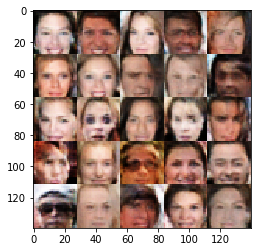

Epoch 1/1... Discriminator Loss: 1.2583... Generator Loss: 0.6562
Epoch 1/1... Discriminator Loss: 1.0501... Generator Loss: 0.8700
Epoch 1/1... Discriminator Loss: 1.0753... Generator Loss: 0.8145
Epoch 1/1... Discriminator Loss: 1.0764... Generator Loss: 0.9250
Epoch 1/1... Discriminator Loss: 1.1402... Generator Loss: 0.9880
Epoch 1/1... Discriminator Loss: 1.1080... Generator Loss: 0.7678
Epoch 1/1... Discriminator Loss: 1.0571... Generator Loss: 0.9222
Epoch 1/1... Discriminator Loss: 1.1424... Generator Loss: 0.6884
Epoch 1/1... Discriminator Loss: 0.9900... Generator Loss: 0.9686
Epoch 1/1... Discriminator Loss: 1.0183... Generator Loss: 0.8889


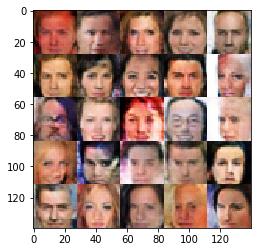

Epoch 1/1... Discriminator Loss: 1.1098... Generator Loss: 1.5536
Epoch 1/1... Discriminator Loss: 1.1809... Generator Loss: 0.6588
Epoch 1/1... Discriminator Loss: 1.1216... Generator Loss: 0.9192
Epoch 1/1... Discriminator Loss: 1.0651... Generator Loss: 1.0995
Epoch 1/1... Discriminator Loss: 1.1338... Generator Loss: 0.7873
Epoch 1/1... Discriminator Loss: 1.2682... Generator Loss: 0.6586
Epoch 1/1... Discriminator Loss: 1.0037... Generator Loss: 0.8657
Epoch 1/1... Discriminator Loss: 0.9716... Generator Loss: 1.1718
Epoch 1/1... Discriminator Loss: 1.2638... Generator Loss: 0.6119
Epoch 1/1... Discriminator Loss: 1.3194... Generator Loss: 0.5322


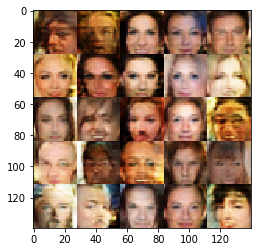

Epoch 1/1... Discriminator Loss: 1.0839... Generator Loss: 0.8492
Epoch 1/1... Discriminator Loss: 1.0510... Generator Loss: 0.8539
Epoch 1/1... Discriminator Loss: 1.2366... Generator Loss: 0.6352
Epoch 1/1... Discriminator Loss: 1.1449... Generator Loss: 0.7778
Epoch 1/1... Discriminator Loss: 1.3541... Generator Loss: 0.6261
Epoch 1/1... Discriminator Loss: 0.8939... Generator Loss: 1.4668
Epoch 1/1... Discriminator Loss: 1.0745... Generator Loss: 0.8408
Epoch 1/1... Discriminator Loss: 1.0261... Generator Loss: 0.8900
Epoch 1/1... Discriminator Loss: 1.1691... Generator Loss: 0.7731
Epoch 1/1... Discriminator Loss: 0.8476... Generator Loss: 1.2686


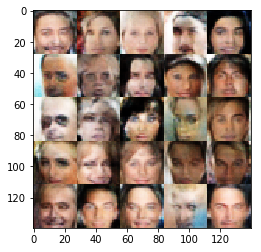

Epoch 1/1... Discriminator Loss: 0.9549... Generator Loss: 1.2440
Epoch 1/1... Discriminator Loss: 0.7994... Generator Loss: 1.2853
Epoch 1/1... Discriminator Loss: 1.1120... Generator Loss: 1.0956
Epoch 1/1... Discriminator Loss: 1.0629... Generator Loss: 0.8947
Epoch 1/1... Discriminator Loss: 1.3179... Generator Loss: 0.5542
Epoch 1/1... Discriminator Loss: 0.9480... Generator Loss: 1.8086
Epoch 1/1... Discriminator Loss: 1.0951... Generator Loss: 1.0272
Epoch 1/1... Discriminator Loss: 1.2093... Generator Loss: 0.7240
Epoch 1/1... Discriminator Loss: 1.0777... Generator Loss: 0.8807
Epoch 1/1... Discriminator Loss: 1.0546... Generator Loss: 0.8646


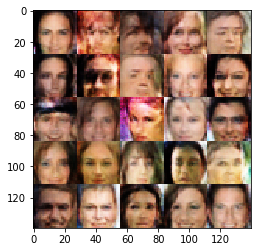

Epoch 1/1... Discriminator Loss: 1.1083... Generator Loss: 0.7340
Epoch 1/1... Discriminator Loss: 1.1345... Generator Loss: 0.8474
Epoch 1/1... Discriminator Loss: 1.1788... Generator Loss: 1.0131
Epoch 1/1... Discriminator Loss: 1.0594... Generator Loss: 1.2413
Epoch 1/1... Discriminator Loss: 1.1689... Generator Loss: 1.2485
Epoch 1/1... Discriminator Loss: 1.1903... Generator Loss: 0.7418
Epoch 1/1... Discriminator Loss: 0.9585... Generator Loss: 1.0625
Epoch 1/1... Discriminator Loss: 0.9284... Generator Loss: 1.0713
Epoch 1/1... Discriminator Loss: 0.9486... Generator Loss: 1.2637
Epoch 1/1... Discriminator Loss: 1.0967... Generator Loss: 0.8322


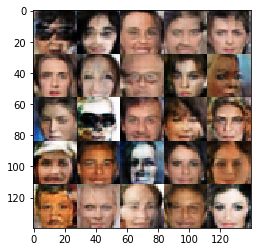

Epoch 1/1... Discriminator Loss: 1.3055... Generator Loss: 0.5914
Epoch 1/1... Discriminator Loss: 1.3341... Generator Loss: 0.6992
Epoch 1/1... Discriminator Loss: 0.9360... Generator Loss: 1.0317
Epoch 1/1... Discriminator Loss: 1.0514... Generator Loss: 1.0084
Epoch 1/1... Discriminator Loss: 1.2089... Generator Loss: 0.6170
Epoch 1/1... Discriminator Loss: 1.1492... Generator Loss: 0.6932
Epoch 1/1... Discriminator Loss: 1.0423... Generator Loss: 0.7913
Epoch 1/1... Discriminator Loss: 1.3882... Generator Loss: 0.5766
Epoch 1/1... Discriminator Loss: 0.9557... Generator Loss: 1.0667
Epoch 1/1... Discriminator Loss: 1.4727... Generator Loss: 0.5085


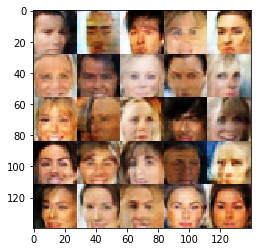

Epoch 1/1... Discriminator Loss: 1.1654... Generator Loss: 1.3781
Epoch 1/1... Discriminator Loss: 1.2724... Generator Loss: 0.6856
Epoch 1/1... Discriminator Loss: 0.8975... Generator Loss: 1.4199


In [12]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.